In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
import pickle

from tqdm import tqdm

import numpy as np

import pandas as pd

from umap import UMAP

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from modules.models.supervised.baselines import Lag1Model
from modules.utils.general_utils.utilities import group_wise_binning
from modules.utils.model_utils.metrics_losses import smape_k
from modules.utils.general_utils.utilities import load_full_model
from modules.utils.general_utils.visualizers import visualize_temporal_panel, visualize_full_panel

In [24]:
def compute_aic(n, sse, k):
    """Return the akaice information criteria
    
    Para:
      - n: int, number of observations.
      - sse: float, insampe sum of squared errors.
      - k: int, number of parameters.
      
    Returns:
      - aic: float, akaike information criteria. 
    """
    aic = (n * np.log(sse/n)) + (2*k)
    return aic


def compute_min_max(values):
    """Compute Min Max Scaling
    
    Para:
        - values: ndarray, array to be scaled
    
    Returns:
        - scaled: ndarray, scalled version of values
    """
    mini = np.min(values)
    maxi = np.max(values)
    scaled = (values - mini) / (maxi - mini)
    return scaled


def plot_log_minmax_transform(examples):
    """Plot the effect of applying log transform and 
    subsequenly min max scaling
    
    Para:
        - values: dict, keys are the data generating process 
            values are the generated sample
    
    Returns:
        - None
    """
    fig, axs = plt.subplots(
        len(examples), 
        3, 
        figsize=(3 * 4, len(examples) * 4), 
        sharey=True
    )
    idx = 0
    for label, values in examples.items():
    
        log_values = np.log(values)

        sns.histplot(
            values,
            ax=axs[idx][0]
        )
        axs[idx][0].set_title(label)
        sns.histplot(
            compute_min_max(values),
            ax=axs[idx][1]
        )
        axs[idx][1].set_title('$MinMax$')
        sns.histplot(
            compute_min_max(log_values),
            ax=axs[idx][2]
        )
        axs[idx][2].set_title('$MinMax(log)$')
        
        idx += 1

    plt.tight_layout()
    plt.show()
    return None


def quick_shuffle_extractor(encoder_objs, root, batches, max_seq=4):
    """Extract the embedding generated by a trained model
    
    Throw-away function extrapolating embedding extrraction
    from the embedding extraction pipeline. It shuffle the
    embeddings for simulating the result of a null model.
    
    Para:
        - encoders_obj: dict, keys are the encoders names
            values are the actual encoders.
        - root: str, root directory for the concoders,
        - batches: array, list of batches of data to be encoded
        - max_seq: int, maximum number of sequences to consider.
    
    Returns:
        - None    
    """
    for enc_name, enc_obj in encoder_objs.items():

        print(f'Extracting embedding for {enc_name}')
        collection_snapshots = {
            snapshot: [] for snapshot in range(max_seq)
        }
        final_state = []

        for batch in tqdm(batches):

            inputs = []
            for inp_name in enc_obj['inp_names']:

                inp = np.load(f'{root}\\{inp_name}\\{batch}.npy')
                
                original_shape = inp.shape
                
                # we shuffle the input metrics
                inp = inp.flatten()
                np.random.shuffle(inp)
                inputs.append(inp.reshape(original_shape))

            predicted_embedding = enc_obj['encoder'].predict(inputs)
            batch_size, time_size, space_size = predicted_embedding.shape
            for time_step in range(max_seq):

                if time_step > (time_size - 1):
                    empty_batch = np.empty((batch_size, space_size))
                    empty_batch[:] = np.nan
                    collection_snapshots[time_step].append(
                        empty_batch
                    )
                else:
                    collection_snapshots[time_step].append(
                        predicted_embedding[:, time_step, :]
                    )

        for snapshot, embedding in collection_snapshots.items():

            embedding = np.vstack(embedding)
        
        return embedding

# Define Globals

In [25]:
FEATURES_PATH = 'data\\train\\inputs\\continuous_features'
INPUTS = [
    'continuous_features',
    'context'
]
TARGETS = [
    'tar_delta_sessions',
    'tar_active_time',
    'tar_session_time',
    'tar_activity',
    'tar_sessions',
]
CMAP = matplotlib.cm.get_cmap('Paired')
SNAPSHOTS = 10

with open('results\\saved_objects\\scalers\\global.pkl', 'rb') as pickle_file:
    SCALER = pickle.load(pickle_file)

BTCH = [i for i in range(len(os.listdir(FEATURES_PATH)))]
TS_BTCH = BTCH[0::5]
TR_BTCH = [batch for batch in BTCH if batch not in TS_BTCH]

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Load Remappers

In [26]:
TARGETS_RMP = {
    'tar_delta_sessions': 'Future Absence',    
    'tar_active_time': 'Future Active Time',
    'tar_session_time': 'Future Session Time',
    'tar_activity': 'Future Session Activity',
    'tar_sessions': 'Future N° Sessions'
}
with open('results\\saved_objects\\mappers\\context.pkl', 'rb') as pickle_file:
    CONTEXT_RMP = pickle.load(pickle_file) 
CONTEXT_RMP = {value: key for key, value in CONTEXT_RMP.items()}

# Load Data Containers

In [27]:
with (open('results\\saved_data_containers\\melchior.pkl', 'rb')) as container:
    data_container_rnn = pickle.load(container)
with (open('results\\saved_data_containers\\td_mlp.pkl', 'rb')) as container:
    data_container_mlp = pickle.load(container)

## Log Transform Simulations

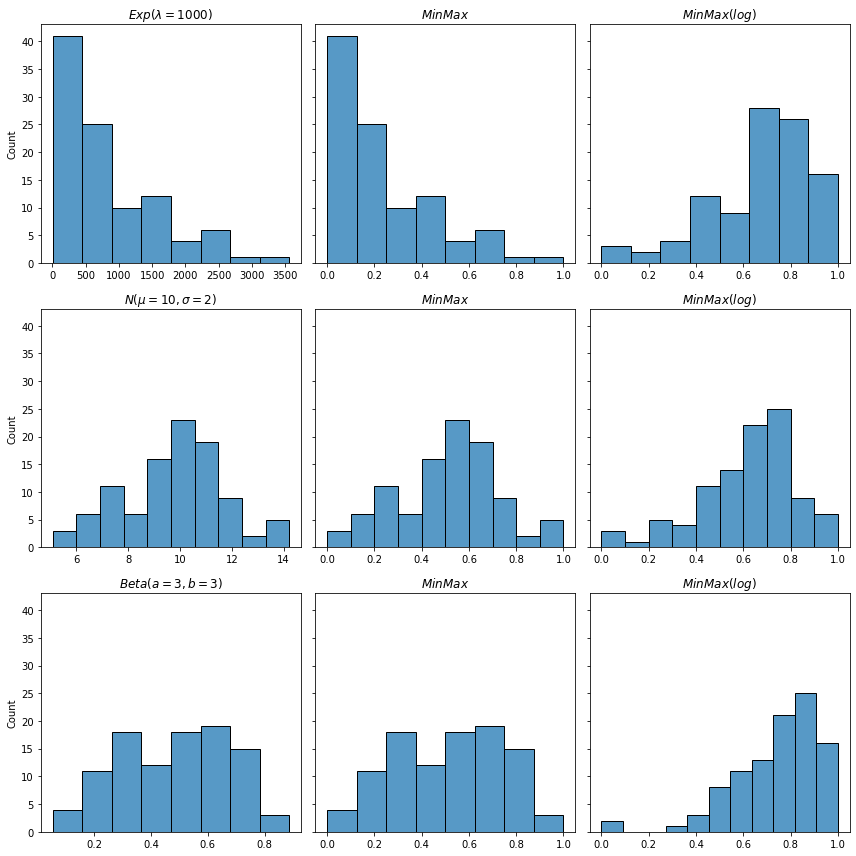

In [20]:
plot_log_minmax_transform(
    examples={
        # this is the type of skewed metric observed in the paper
        '$Exp(\lambda = 1000)$': np.random.exponential(1000, size=100), 
        '$N(\mu = 10, \sigma = 2)$': np.random.normal(10, 2, size=100), 
        '$Beta(a = 3, b=3)$': np.random.beta(3, 3, size=100)
    }
)

## Akaike Information Criteria

In [5]:
rnn_model = load_full_model(
    name='melchior',
    optimizer='adam',
    custom_objects={'smape_k': smape_k},
    loss={
        'output_absence_act': smape_k,
        'output_active_act': smape_k,
        'output_sess_time_act': smape_k,
        'output_activity_act': smape_k,
        'output_sess_act': smape_k
    },
    metrics={
        'output_absence_act': smape_k,
        'output_active_act': smape_k,
        'output_sess_time_act': smape_k,
        'output_activity_act': smape_k,
        'output_sess_act': smape_k
    },
    path='results\\saved_trained_models\\{}'
)

lag_model = Lag1Model(
    n_features=4
)
lag_model.fit()

In [6]:
PRED_LAG = {
    target: [] for target in TARGETS
}
PRED_RNN = {
    target: [] for target in TARGETS
}
for btch in tqdm(TR_BTCH):

    input_features = []

    for inp in INPUTS:

        array = np.load(f'data\\train\\inputs\\{inp}\\{btch}.npy')
        input_features.append(array)
    
    if array.shape[1] < 4:
        continue
    else:
        btch_context = np.load(
            f'data\\train\\inputs\\context\\{btch}.npy'
        )
        input_features.append(btch_context)


        original_shape = input_features[0].shape
        features = input_features[0].reshape((-1, 4))
        features = SCALER.inverse_transform(features)
        features = features.reshape(original_shape)
        
        list_pred_rnn = rnn_model._model.predict(
            input_features,
            batch_size=array.shape[0]
        )
        list_pred_lag = lag_model._model.predict(
            features,
            batch_size=array.shape[0]
        )

        
        for index, target in enumerate(TARGETS):
            
            PRED_LAG[target].append(
                list_pred_lag[index][:, 3, :].reshape(-1, 1)
            )
            PRED_RNN[target].append(
                list_pred_rnn[index][:, 3, :].reshape(-1, 1)
            )
            
for target in TARGETS: 
    
    PRED_LAG[target] = np.vstack(PRED_LAG[target])
    PRED_RNN[target] = np.vstack(PRED_RNN[target])

 42%|█████████████████████████████████                                             | 3829/9034 [03:39<21:14,  4.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 9034/9034 [15:20<00:00,  9.82it/s]


In [7]:
GT = {
    target: [] for target in TARGETS
}

for btch in tqdm(TR_BTCH):
    
    for target in TARGETS:
        
        # akaike is computed insample
        ground_truth_array = np.load(
            f'data\\train\\targets\\{target}\\{btch}.npy'
        )
        if ground_truth_array.shape[1] < 4:
            continue
        else:
            GT[target].append(
                ground_truth_array[:, 3, :].reshape(-1, 1)
            )
            
for target in TARGETS: 
    
    GT[target] = np.vstack(GT[target])

100%|██████████████████████████████████████████████████████████████████████████████| 9034/9034 [04:45<00:00, 31.60it/s]


In [8]:
N = PRED_LAG['tar_delta_sessions'].shape[0]

K_RNN = 145293
K_LAG = 1

BIC_DF = pd.DataFrame(columns=['Model', 'Target', 'Parameters', 'SSE', 'N', 'AIC'])

index = 0
for target in TARGETS:
    
    gt = GT[target]
    p_rnn = PRED_RNN[target]
    p_lag = PRED_LAG[target]

    sse_rnn = np.sum((gt - p_rnn) ** 2)
    sse_lag = np.sum((gt - p_lag) ** 2)

    bic_rnn = compute_aic(
        N, 
        sse_rnn, 
        K_RNN
    )
    bic_lag = compute_aic(
        N, 
        sse_lag, 
        K_LAG
    )
    
    BIC_DF.loc[index] = [
        'RNN',
        target,
        K_RNN,
        sse_rnn,
        N,
        bic_rnn
    ]
    BIC_DF.loc[index + 1] = [
        'Lag 1',
        target,
        K_LAG,
        sse_lag,
        N,
        bic_lag
    ]
    
    index += 2

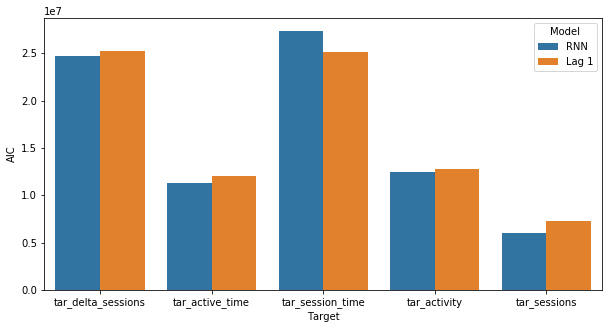

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(
    y='AIC',
    x='Target',
    hue='Model',
    data=BIC_DF
)
#plt.yscale('log')

## Scrambled Data Embedding

In [53]:
encoders = {
    'melchior': '0_lstm_layer_features'
}
encoder_objs = {}

###############################################################################

for model_name, out_layer in encoders.items():

    print(f'Extracting embedding for {model_name}')

    model = load_full_model(
        name=model_name,
        optimizer='adam',
        loss={
            'output_absence_act': smape_k,
            'output_active_act': smape_k,
            'output_sess_time_act': smape_k,
            'output_activity_act': smape_k,
            'output_sess_act': smape_k
        },
        metrics={
            'output_absence_act': smape_k,
            'output_active_act': smape_k,
            'output_sess_time_act': smape_k,
            'output_activity_act': smape_k,
            'output_sess_act': smape_k
        }
    )

    engagement_encoder = model.get_encoder(
        out_layer=out_layer
    )
    
encoder_objs[f'random_melc_eng_emb'] = {
        'encoder': engagement_encoder,
        'inp_names': [
            'continuous_features',
            'context',
        ]
}

embeddings = quick_extractor(
    encoder_objs=encoder_objs,
    root='data\\train\\inputs',
    batches=TS_BTCH,
)

Extracting embedding for melchior
Extracting embedding for random_melc_eng_emb


100%|██████████████████████████████████████████████████████████████████████████████| 2259/2259 [03:40<00:00, 10.26it/s]


In [70]:
nan_mask = np.isnan(embeddings).any(axis=1)
embeddings = embeddings[~nan_mask]
        
reduction = UMAP(
    n_components=2,
    verbose=True,
    n_neighbors=100,
    n_epochs=1000,
    min_dist=0.80,
    metric='cosine'
).fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.8, n_epochs=1000, n_neighbors=100, verbose=True)
Fri Dec 10 11:27:53 2021 Construct fuzzy simplicial set
Fri Dec 10 11:27:53 2021 Finding Nearest Neighbors
Fri Dec 10 11:27:53 2021 Building RP forest with 38 trees
Fri Dec 10 11:28:02 2021 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	Stopping threshold met -- exiting after 3 iterations
Fri Dec 10 11:39:36 2021 Finished Nearest Neighbor Search
Fri Dec 10 11:40:06 2021 Construct embedding



Fri Dec 10 12:18:59 2021 Finished embedding


In [71]:
INPUTS_PATH = 'data\\train\\inputs\\{}'
TARGETS_PATH = 'data\\train\\targets\\{}'

CMAP = matplotlib.cm.get_cmap('Paired')

SNAPSHOTS = 10

INPUTS = ['continuous_features', 'context']
TARGETS = [
    'tar_sessions',
    'tar_delta_sessions',    
    'tar_active_time',
    'tar_session_time',
    'tar_activity'
]

MODELS_RMP = { 
    'melchior': 'RNN'
}
TARGETS_RMP = {
    'tar_delta_sessions': 'Future Absence',    
    'tar_active_time': 'Future Active Time',
    'tar_session_time': 'Future Session Time',
    'tar_activity': 'Future Session Activity',
    'tar_sessions': 'Future N° Sessions'
}
with open('results\\saved_objects\\mappers\\context.pkl', 'rb') as pickle_file:
    CONTEXT_RMP = pickle.load(pickle_file) 
CONTEXT_RMP = {value: key for key, value in CONTEXT_RMP.items()}

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:84: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


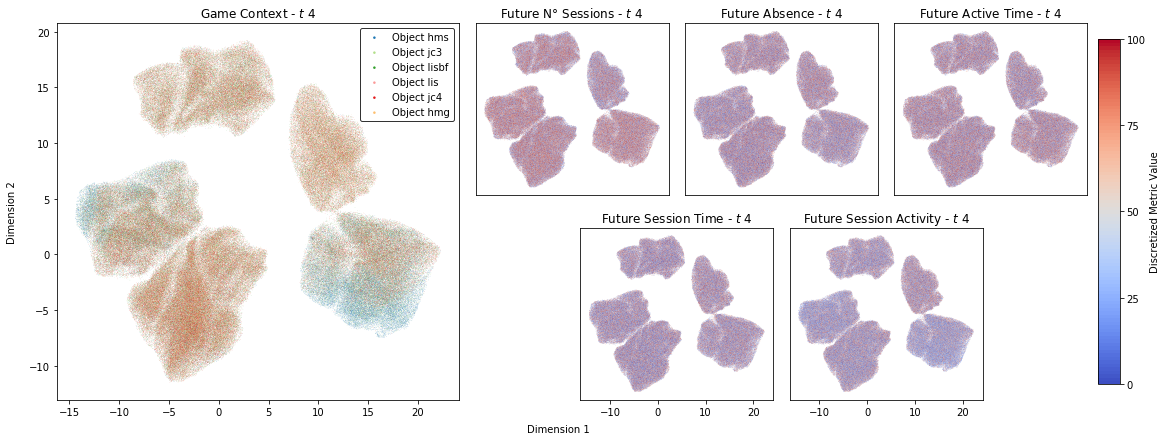

In [81]:
predictions = data_container['prediction']
contexts = data_container['context'][3]
colors_dict = {target_name: None for target_name in TARGETS}

for color_name, array in colors_dict.items():

    binned_array = group_wise_binning(
        array=predictions[color_name][3],
        grouper=contexts,
        n_bins=100,
        method='discret'
    )
    colors_dict[color_name] = binned_array
    
fig = plt.figure(figsize=(15, 6), constrained_layout=True)
spec = fig.add_gridspec(ncols=10, nrows=2)

ax_context = fig.add_subplot(spec[:, :4])
axs_metrics = [
    fig.add_subplot(spec[0, 4:6]),
    fig.add_subplot(spec[0, 6:8]),
    fig.add_subplot(spec[0, 8:]),
    fig.add_subplot(spec[1, 5:7]),
    fig.add_subplot(spec[1, 7:9])
]

for unique_context in np.unique(contexts):

    label = CONTEXT_RMP[int(unique_context)]
    context_index = np.argwhere(
        contexts == unique_context
    ).flatten()

    ax_context.scatter(
        reduction[:, 0][context_index],
        reduction[:, 1][context_index],
        marker='o',
        edgecolor='',
        color=CMAP(int(unique_context)),
        label='Object {}'.format(label),
        s=0.1
    )
ax_context.set_ylabel('')
ax_context.set_xlabel('')
ax_context.set_title(f'Game Context - $t$ 4')

index = 0
for color_name, ax_metric in zip(colors_dict.keys(), axs_metrics):

    img = ax_metric.scatter(
        reduction[:, 0],
        reduction[:, 1],
        c=colors_dict[color_name],
        marker='o',
        edgecolor='',
        cmap='coolwarm',
        vmin=0,
        vmax=100,
        s=0.1
    )
    ax_metric.set_title(
        f'{TARGETS_RMP[color_name]} - $t$ 4'
    )
    if index > 2:
        ax_metric.set_yticks([])
        ax_metric.set_xlabel('')
    else:
        ax_metric.set_yticks([])
        ax_metric.set_xticks([])
    index += 1

fig.text(0.5, -0.01, 'Dimension 1', ha='center')
fig.text(-0.01, 0.5, 'Dimension 2', va='center', rotation='vertical')
handles, labels = ax_context.get_legend_handles_labels()
leg = ax_context.legend(
    handles,
    labels,
    markerscale=8,
    ncol=1
)
leg.get_frame().set_edgecolor('k')

plt.tight_layout()

cbaxes = fig.add_axes([1.0, 0.1, 0.02, 0.8])
cbar = fig.colorbar(
    img,
    cax=cbaxes,
    cmap='coolwarm',
    boundaries=np.linspace(0, 100, 100),
    ticks=[0, 25, 50, 75, 100]
)
cbar.set_label('Discretized Metric Value')